# Digital Earth Australia Intertidal workflow

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [2]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


### Load packages

In [8]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from ipyleaflet import basemaps, basemap_to_tiles

import datacube
import odc.geo.xr
from odc.geo.geom import Geometry
from odc.algo import mask_cleanup
from odc.ui import select_on_a_map

from intertidal.utils import (
    round_date_strings,
    export_intertidal_rasters,
    intertidal_hillshade,
                            )
from intertidal.tide_modelling import pixel_tides_ensemble
from intertidal.elevation import load_data, load_topobathy, elevation
from intertidal.extents import extents
from intertidal.exposure import exposure
from intertidal.tidal_bias_offset import bias_offset, tidal_offset_tidelines

from dea_tools.dask import create_local_dask_cluster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup


### Set analysis parameters

In [9]:
# Intertidal Elevation variables
start_date = "2019"  # Start date for analysis
end_date = "2021"  # End date for analysis
resolution = 300  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = True  # Filter to remove poorly georeferenced scenes?
tide_model = "ensemble"  # Tide model to use in analysis
# tide_model_dir = "/var/share/tide_models"  # Directory containing tide model files
# tide_model = ["FES2014", "FES2012", "TPXO9-atlas-v5"]
tide_model_dir = "/gdata1/data/tide_models_clipped"

# Exposure variables
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'
filters=['unfiltered'] # Exposure filters

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
all_timerange = pd.date_range(
    start=round_date_strings(start_date, round_type="start"),
    end=round_date_strings(end_date, round_type="end"),
    freq=modelled_freq,
)

#### Set study area

##### Option 1: load study area from 32 km tile GridSpec

In [10]:
# # Set study area (e.g. tile ID in form 'x143y87')
# study_area = "x139y96"
# geom = None  # Use GridSpec to load study area, not a custom geom

##### Option 2: load study area from vector file

In [11]:
# # Set study area to load from file
# study_area = "pointstuart"

# # Read file, select study area and convert to geom
# studyarea_gdf = gpd.read_file(
#     "data/raw/intertidal_development_polygons.geojson"
# ).set_index("id")
# geom = Geometry(studyarea_gdf.loc[study_area].geometry, crs=studyarea_gdf.crs)
# geom

##### Option 3: load study area using interactive map

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

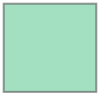

In [12]:
# Set study area name for outputs
study_area = "test"

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height="600px", layers=(basemap,), center=(-26, 135), zoom=4)
geom

## Intertidal workflow

### Load data

In [13]:
%%time

# Connect to datacube
dc = datacube.Datacube(app="Intertidal_elevation")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds = load_data(
    dc=dc,
    study_area=study_area,
    geom=geom,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    include_s2=True,
    
    include_ls=True,
    filter_gqa=filter_gqa,
    max_cloudcover=90,
    skip_broken_datasets=True,
)

print(satellite_ds)

# Load data
satellite_ds.load()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 31,Total memory: 237.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45473,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Total threads: 31
Started: Just now,Total memory: 237.21 GiB
Comm: tcp://127.0.0.1:34733,Total threads: 31
Dashboard: /user/claire.phillips@ga.gov.au/proxy/41421/status,Memory: 237.21 GiB
Nanny: tcp://127.0.0.1:41137,


<xarray.Dataset>
Dimensions:      (time: 325, y: 8, x: 8)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-02T01:43:54.866588 ... 2021-12...
  * y            (y) float64 -1.776e+06 -1.776e+06 ... -1.778e+06 -1.778e+06
  * x            (x) float64 -9.632e+05 -9.628e+05 ... -9.614e+05 -9.61e+05
    spatial_ref  int32 3577
Data variables:
    ndwi         (time, y, x) float32 dask.array<chunksize=(1, 8, 8), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


CPU times: user 5.91 s, sys: 353 ms, total: 6.26 s
Wall time: 50.4 s


<xarray.Dataset>
Dimensions:      (time: 325, y: 8, x: 8)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-02T01:43:54.866588 ... 2021-12...
  * y            (y) float64 -1.776e+06 -1.776e+06 ... -1.778e+06 -1.778e+06
  * x            (x) float64 -9.632e+05 -9.628e+05 ... -9.614e+05 -9.61e+05
    spatial_ref  int32 3577
Data variables:
    ndwi         (time, y, x) float32 -0.1757 -0.2092 ... -0.3439 -0.1218
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Load optional topobathy mask
Loads a topo-bathymetric DEM for the extents of the loaded satellite data.
This is used as a coarse mask to constrain the analysis to the coastal zone, improving run time and reducing clear false positives over deep water or elevated land.

In [14]:
# Load data from GA's Australian Bathymetry and Topography Grid 2009
topobathy_ds = load_topobathy(
    dc, satellite_ds, product="ga_multi_ausbath_0", resampling="bilinear"
)

### Intertidal elevation
To run without the topobathy DEM mask, comment out `valid_mask=...`.

In [15]:
# %reload_ext autoreload

# Model elevation for each pixel
ds, ds_aux, tide_m = elevation(
    satellite_ds,
    valid_mask=topobathy_ds.height_depth > -20,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
)

2024-01-22 06:09:45 INFO Modelling tide heights for each pixel


Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:19<00:00,  1.81it/s]


Returning low resolution tide array
Generating ensemble tide model from point inputs


2024-01-22 06:10:07 INFO Masking nodata and adding tide heights to satellite data array
2024-01-22 06:10:07 INFO Flattening satellite data array and filtering to intertidal candidate pixels
2024-01-22 06:10:07 INFO Applying valid data mask to constrain study area
2024-01-22 06:10:07 INFO Running per-pixel rolling median


Reducing analysed pixels from 64 to 16 (25.00%)


  0%|          | 0/105 [00:00<?, ?it/s]

2024-01-22 06:10:07 INFO Modelling intertidal elevation
2024-01-22 06:10:07 INFO Modelling intertidal uncertainty
2024-01-22 06:10:07 INFO Unflattening data back to its original spatial dimensions
2024-01-22 06:10:07 INFO Cleaning inaccurate upper intertidal pixels
2024-01-22 06:10:07 INFO Successfully completed intertidal elevation modelling


Applying tidal interval interpolation to 200 intervals
Applying rolling mean smoothing with radius 20


### Intertidal extents


In [16]:
ds["extents"] = extents(
    freq=ds_aux.ndwi_wet_freq, dem=ds.elevation, corr=ds_aux.ndwi_tide_corr
)

In [17]:
# ## Plot
# labels=['0 Dry',
#        '1 Intermittent\n   wet\n   inland',
#        '2 Wet inland',
#        '3 Wet ocean',
#        '4 Intertidal lc',
#        '5 Intertidal hc',
#        ]

# fig,ax=plt.subplots(figsize=(12,8))
# cax=ax.imshow(ds['extents'], cmap='terrain_r')
# cbar=fig.colorbar(cax, ticks=[0,1,2,3,4,5])
# cbar.ax.set_yticklabels(labels)
# plt.show()

### Intertidal exposure
Calculate exposure using the script function

In [18]:
## Temp - override 'filters' def from earlier cell during interoperabile filters testing

filters=['Jan']

ModelledTides = ValueError: cannot reindex or align along dimension 'dim_0' because of conflicting dimension sizes: {73, 74}


ModelledTides[0] = TypeError: only integer scalar arrays can be converted to a scalar index 

442 ## Extract the peak height dates
443 tide_cq = springhighs_all.tide_m.quantile(q=calculate_quantiles,dim='time')



In [26]:
%reload_ext autoreload
## Commented code relates to work-in-progress custom exposure filtering

# ds["exposure"], tide_cq = exposure(
#     start_date=start_date,
#     end_date=end_date,
#     dem=ds.elevation,
#     time_range=all_timerange,
#     tide_model=tide_model,
#     tide_model_dir=tide_model_dir,
#     # mod_timesteps = modelled_freq,
# )

# exposure_filters, tide_cq_dict = exposure(
exposure_filters, tide_cq_dict, timeranges = exposure(
# ModelledTides_ensemble=exposure(
    dem=ds.elevation,
    time_range=all_timerange,
    modelled_freq = modelled_freq,
    tide_model=tide_model,
    # tide_model='FES2014',
    tide_model_dir=tide_model_dir,
    filters=filters,
    filters_combined=[('dry','Spring_high')]
)

for x in list(exposure_filters.keys()):
    ds['exposure_'+str(x)]=exposure_filters[str(x)]

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:20<00:00,  1.71it/s]


Returning low resolution tide array
Generating ensemble tide model from point inputs
Calculating temporal filter: Jan
Calculating temporal filter: dry
Calculating statial filter: Spring_high
Calculating Spring_high
saving Spring_high ds to timeranges
completed saving springhigh ds to timeranges
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
100%|██████████| 35/35 [00:18<00:00,  1.89it/s]


Computing tide quantiles
Returning low resolution tide array
Generating ensemble tide model from point inputs
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:19<00:00,  1.79it/s]


Computing tide quantiles
Returning low resolution tide array
Generating ensemble tide model from point inputs
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:18<00:00,  1.92it/s]


Computing tide quantiles
Returning low resolution tide array
Generating ensemble tide model from point inputs


In [ ]:
timeranges#2['Spring_high'].isel(x=1,y=1).time

# ## Take the datetimes from the first pixel and translate into a Pandas DatetimeIndex.
# pd.to_datetime(timeranges2['Spring_high'].isel(x=1,y=1).time)

In [ ]:
timeranges['winter'].intersection(pd.to_datetime(timeranges['Spring_high'].isel(x=1,y=1).time))

In [ ]:
temporal_filters = ['dry', 'wet', 'summer', 'autumn', 'winter', 'spring', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Daylight', 'Night']
spatial_filters = ['Spring_high', 'Spring_low', 'Neap_high', 'Neap_low', 'Hightide', 'Lowtide']

# Create a list of tuples for every combination of elements in temporal_filters and spatial_filters
combinations = [(temporal, spatial) for temporal in temporal_filters for spatial in spatial_filters]

# Print the result
print(combinations)


In [ ]:
print(combinations[0])
print(combinations[0][0])

In [ ]:
# timeranges2['Spring_high'].isel(x=1,y=1).time.all() == timeranges2['Spring_high'].isel(x=10,y=10).time.all()

test1 = ['a','b','c','d','e']
test2 = ['a','c','f','g','h']

for x in test2:
    if x not in test1:
        print(x)


In [ ]:
filt = ['dry','wet','Hightide']

filt.append(combinations[0][0]) if combinations[0][0] not in filt else next

filt

In [ ]:
combinations[0][0] not in filt

In [ ]:
ds.exposure_Lowtide.plot()

In [ ]:
ds.exposure_Hightide.plot()

In [ ]:
ModelledTides = ModelledTides_ensemble.copy(deep=True)

In [ ]:
ModelledTides_FES

In [ ]:
## TEMP
import re
import pandas as pd
from scipy.signal import argrelmax, argrelmin

# # Extract the modelling freq units
# Split the number and text characters in modelled_freq
freq_time = int(re.findall(r'(\d+)(\w+)', modelled_freq)[0][0])
freq_unit = str(re.findall(r'(\d+)(\w+)', modelled_freq)[0][-1])

# Extract the number of modelled timesteps per 14 days (half lunar cycle) for neap/spring calcs
mod_timesteps = pd.Timedelta(14,"d")/pd.Timedelta(freq_time, freq_unit)

## Identify kwargs for peak detection algorithm
order=(int(mod_timesteps/2))

calculate_quantiles = np.linspace(0, 1, 1001)

In [ ]:
## Temp-testing failing spatial filters
## Original workflow used ModelledTides[0] which drops the time dimension

# ModelledTides
# ModelledTides[0]

## stack the y and x dimensions
# stacked_everything = ModelledTides[0].stack(z=['y','x']).groupby('z') ##This one takes timestep 0 only
stacked_everything = ModelledTides.stack(z=['y','x']).groupby('z') 

print ('Calculating Spring_high')

## apply the peak detection routine
stacked_everything_high = stacked_everything.apply(
    lambda x: xr.DataArray(argrelmax(x.values, order=order)[0])
    )
## Unstack
springhighs_all = stacked_everything_high.unstack('z')
##Reorder the y axis. Uncertain why it gets reversed during the stack/unstack.
springhighs_all = springhighs_all.reindex(y=springhighs_all.y[::-1])
## Rename the time axis
springhighs_all = springhighs_all.rename({'dim_0':'time'})
## Convert to dataset
springhighs_all = springhighs_all.to_dataset(name = 'time')
## Reorder the dims
springhighs_all = springhighs_all[['time','y','x']]

# Select dates associated with detected peaks
## removed reference below to ModelledTides[0]. Possibly an artefact of new 
## pixel_tides_ensemble func. If using pixel_tides, may need to revert to ModelledTides[0].

# springhighs_all = ModelledTides[0].to_dataset().isel(time=springhighs_all.time)
springhighs_all = ModelledTides.to_dataset().isel(time=springhighs_all.time) 

# ##TEMP-interoperable filters testing
# print('saving Spring_high ds to timeranges')
# timeranges['Spring_high'] = springhighs_all
# print('completed saving springhigh ds to timeranges')

## Extract the peak height dates
tide_cq = springhighs_all.tide_m.quantile(q=calculate_quantiles,dim='time')

# Add tide_cq to output dict
tide_cq_dict=tide_cq

# Calculate the tide-height difference between the elevation value and
# each percentile value per pixel
diff = abs(tide_cq - dem)

# Take the percentile of the smallest tide-height difference as the
# exposure % per pixel
idxmin = diff.idxmin(dim="quantile")

# Convert to percentage
exposure_Spring_high = idxmin * 100

In [ ]:
# stacked_everything = ModelledTides.stack(z=['y','x']).groupby('z') 

stacked_everything_high = stacked_everything.apply(
    lambda x: xr.DataArray(argrelmax(x.values, order=order)[0])
    )


# ModelledTides.stack(z=['y','x']).groupby('z')
# stacked_everything
# ModelledTides
# 'tide_m'time: 8761y: 482x: 715
#344630 groups
# 482*715

In [ ]:
ModelledTides

In [ ]:
se0=ModelledTides[0].stack(z=['y','x']).groupby('z') 
se=ModelledTides.stack(z=['y','x']).groupby('z') 

In [ ]:
print(se0)

In [ ]:
print(se)

In [ ]:
stacked_everything_high = stacked_everything.apply(
    lambda x: xr.DataArray(argrelmax(x.values, order=order))#[0])
    )

In [ ]:
len(stacked_everything_high)/(order)
8761/order

In [ ]:
# mod_timesteps
ModelledTides_ensemble=ModelledTides.copy(deep=True)

In [ ]:
springhighs_all##ModelledTides[0]

In [ ]:
## TEmp

timeranges

### Spread and offset
Calculate the spread and high/low tide biases of input observed images as a percentage of the modelled tide heights.


In [ ]:
(
    ds["oa_lat"],
    ds["oa_hat"],
    ds["oa_lot"],
    ds["oa_hot"],
    ds["oa_spread"],
    ds["oa_offset_lowtide"],
    ds["oa_offset_hightide"],
) = bias_offset(
    tide_m=tide_m, tide_cq=tide_cq_dict['unfiltered'], extents=ds.extents, lot_hot=True, lat_hat=True
)

### Tideline confidence

In [ ]:
# (hightideline, lowtideline, tidelines_gdf) = tidal_offset_tidelines(
#     extents=ds.extents,
#     offset_hightide=ds.oa_offset_hightide,
#     offset_lowtide=ds.oa_offset_lowtide,
#     distance=250,
# )

## Plot all layers

In [ ]:
# Inspect contents of ds before plotting
ds

In [ ]:
fig = plt.figure(figsize=(16, 18), tight_layout=True)
ax_dict = fig.subplot_mosaic(
    """
    AAAABBBBCCCC
    DDDEEEFFFGGG
    HHHIIIJJJKKK
    LLLMMM......
    """,
    height_ratios=[1, 0.8, 0.8, 0.8],
)

# label_params = dict(add_labels=False, yticks=[], xticks=[])

# Plot Elevation with hillshade
ds["elevation"].plot.imshow(
    ax=ax_dict["A"],
    cmap="viridis",
    interpolation="bilinear",
)
intertidal_hillshade(ds["elevation"], ds["extents"], vert_exag=300).plot.imshow(
    ax=ax_dict["A"],
    interpolation="bilinear",
)
ax_dict["A"].set_title("Elevation (metres AMSL)")

# Plot uncertainty
ds["elevation_uncertainty"].plot.imshow(
    ax=ax_dict["B"],
    cmap="magma",
    interpolation="bilinear",
)
ax_dict["B"].set_title("Elevation uncertainty (metres)")
ax_dict["B"].set_facecolor("#2E2E2E")

# Plot Exposure
ds["exposure"].plot.imshow(
    ax=ax_dict["C"],
    cmap="RdYlGn",
    levels=np.arange(0, 100, 1),
    add_labels=False,
    yticks=[],
)
ax_dict["C"].set_title("Exposure")

# Plot Extents
ds["extents"].astype(np.int16).plot.imshow(ax=ax_dict["D"])
ax_dict["D"].set_title("Extents")

# Plot the observation spread
ds["oa_spread"].plot.imshow(
    ax=ax_dict["E"],
    vmin=0,
    vmax=100,
    cmap="magma",
    cbar_kwargs={"label": "% of tidal range observed"},
)
ax_dict["E"].set_title("Observation Spread (%)")

# Plot the high-tide offset
ds["oa_offset_hightide"].plot.imshow(
    ax=ax_dict["F"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of high tide never observed"},
)
ax_dict["F"].set_title("High-tide offset (%)")

# Plot the low-tide offset
ds["oa_offset_lowtide"].plot.imshow(
    ax=ax_dict["G"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of low tide never observed"},
)
ax_dict["G"].set_title("Low-tide offset (%)")

# Plot the LAT
ds["oa_lat"].plot.imshow(
    ax=ax_dict["H"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
    add_labels=False,
)
ax_dict["H"].set_title("Lowest Astronomical Tide")

# Plot the LOT
ds["oa_lot"].plot.imshow(
    ax=ax_dict["I"], vmin=ds["oa_lat"].min(), vmax=ds["oa_hat"].max()
)
ax_dict["I"].set_title("Lowest Observed Tide")

# Plot the HAT
ds["oa_hat"].plot.imshow(
    ax=ax_dict["J"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
    add_labels=False,
    yticks=[],
)
ax_dict["J"].set_title("Highest Astronomical Tide")

# Plot the HOT
ds["oa_hot"].plot.imshow(
    ax=ax_dict["K"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
)
ax_dict["K"].set_title("Highest Observed Tide")

# Plot the high and low tidelines with respective offset
ax_dict["L"].set_title("Lowtide line and lowtide offset")
# lowtideline.plot(
#     column="offset_lowtide",
#     legend=True,
#     vmin=0,
#     vmax=40,
#     cmap="magma",
#     ax=ax_dict["L"],
#     zorder=2,
# )
# tidelines_gdf.loc[[0], "geometry"].plot(ax=ax_dict["L"], zorder=1)
ax_dict["L"].set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax_dict["L"].set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

ax_dict["M"].set_title("Hightide line and hightide offset")
# hightideline.plot(
#     column="offset_hightide",
#     legend=True,
#     vmin=0,
#     vmax=40,
#     cmap="magma",
#     ax=ax_dict["M"],
#     zorder=2,
# )
# tidelines_gdf.loc[[1], "geometry"].plot(ax=ax_dict["M"], zorder=1)
ax_dict["M"].set_yticks([])
ax_dict["M"].set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax_dict["M"].set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

# Remove axis labels
for label, ax in ax_dict.items():
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")

## Export layers

In [ ]:
# study_area = 'Perth_5pxlandusebuffer'

In [ ]:
# Create output folder. If it doesn't exist, create it
output_dir = f"data/interim/{study_area}/{start_date}-{end_date}"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Save rasters as GeoTIFFs
export_intertidal_rasters(
    ds, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}"
)
export_intertidal_rasters(
    ds_aux, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}_debug"
)

In [ ]:
# Export figure
fig.savefig(f"data/figures/{study_area}_{start_date}_{end_date}.png")

In [ ]:
# Export vector files
hightideline.to_crs("EPSG:4326").to_file(
    f"{output_dir}/{study_area}_{start_date}_{end_date}_offset_hightide.geojson"
)
lowtideline.to_crs("EPSG:4326").to_file(
    f"{output_dir}/{study_area}_{start_date}_{end_date}_offset_lowtide.geojson"
)
tidelines_gdf.to_crs("EPSG:4326").to_file(
    f"{output_dir}/{study_area}_{start_date}_{end_date}_tidelines_highlow.geojson"
)

### Close Dask client

In [ ]:
client.close()